In [141]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 41

import warnings
warnings.simplefilter('ignore')

# Изучаем датасет

## Пути к директориям и файлам 

In [142]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

## Посмотрим на тренировочный датасет 

In [143]:
data = pd.read_csv(TRAIN_DATASET_PATH)
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [144]:
data.shape

(7500, 17)

Видим, что в тренировочном датасете 7500 строк (клиентов), а также 17 признаков.

In [145]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Целевая переменная - Credit Default. В тренировочном датасете представлены все 7500 бинарных значений. А именно: 1 - просрочка по кредиту, 0 - нет просрочки по кредиту. У некоторых признаков, таких как Annual Income (годовой доход), Credit Score (кредитный рейтинг) и особенно Months since last delinquent (количество месяцев с последней просрочки платежа) не хватает значений. В случае с последним признаком может быть тот факт, что клиент новый, кредит только взят, поэтому информации по предыдущим месяцам нет. Вероятно, в этом случае можно заполнить пропуски нулями. В случае с первыми двумя признаками нужно смотреть. Также немного значений не хватает у признаков Years in current job (количество лет на текущем месте работы) и Bankruptcies (банкротства). Думаю, что здесь недостающие значения можно заполнить модой. Все пропуски нужно заполнить, а также добавить новых признаков. Посмотреть, какие признаки хорошие, а какие недостаточно качественные для модели.

In [146]:
data['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Видим, что класс 0 составляет 71,83% от всех значений, а класс 1 - 28,17%. Классы не очень сбалансированы, поэтому будем применять балансировку.

Посмотрим на график распределения:

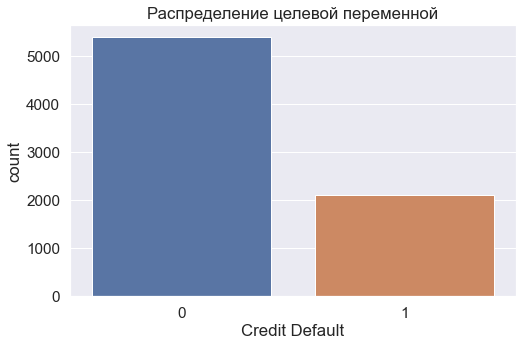

In [147]:
plt.figure(figsize=(8, 5))

sns.countplot(x=data['Credit Default'], data=data)

plt.title('Распределение целевой переменной')
plt.show()

## Посмотрим на тестовый датасет 

In [148]:
test = pd.read_csv(TEST_DATASET_PATH)
test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [149]:
test.shape

(2500, 16)

Видим, что в тестовом датасете 2500 строк (клиентов), а также 16 признаков (нет искомого Credit Default).

In [150]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

Тенденция с пропусками сохраняется, не хватает значений в тех же признаках (и примерно в таком же процентном соотношении). Тестовый датасет нужно обработать по аналогии с тренировочным (заполнить пропуски, добавить новые признаки и т.д.).

## Обработка пропусков 

Пропуски заполним сразу для всех выборок.

Заполним пропуски модой у признаков 'Years in current job', 'Months since last delinquent' и 'Bankruptcies'.

In [151]:
def edit_months_since_last_delinquent(df):
    df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)
    return df

In [152]:
data = edit_months_since_last_delinquent(data)
test = edit_months_since_last_delinquent(test)

In [153]:
def edit_years_in_current_job(df):
    df['Years in current job'] = df['Years in current job'].fillna(df['Years in current job'].mode()[0])
    return df

In [154]:
data = edit_years_in_current_job(data)
test = edit_years_in_current_job(test)

In [155]:
def edit_bankruptcies(df):
    df['Bankruptcies'] = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0])
    return df

In [156]:
data = edit_bankruptcies(data)
test = edit_bankruptcies(test)

Обработаем пропуски у признака 'Annual Income'. Для этого используем медианный доход клиентов по признакам 'Home Ownership' и 'Years in current job'.

In [157]:
data.groupby(['Home Ownership', 'Years in current job'])[['Annual Income']].median()

Annual Income
Home Ownership Years in current job               
Have Mortgage  10+ years                  980685.0
               2 years                   1112640.0
               3 years                   1160463.0
               5 years                         NaN
               6 years                   1111728.0
               8 years                    964136.0
               < 1 year                  1112298.0
Home Mortgage  1 year                    1317897.0
               10+ years                 1396329.0
               2 years                   1319027.5
               3 years                   1454146.0
               4 years                   1403701.0
               5 years                   1339680.5
               6 years                   1390657.5
               7 years                   1299999.0
               8 years                   1320889.5
               9 years                   1261372.0
               < 1 year                  1328670.0
Own Home       1 year                     833910.0
               10+ years                  972420.0
               2 years                    956175.0
               3 years                    872233.0
               4 years                    964098.0
               5 years                   1056476.0
               6 years                   1116839.0
               7 years                    941355.0
               8 years                   1147448.0
               9 years                   1009574.5
               < 1 year                   852435.0
Rent           1 year                     863550.0
               10+ years                 1109790.0
               2 years                    968810.0
               3 years                   1049294.0
               4 years                   1051441.0
               5 years                    964098.0
               6 years                   1021079.0
               7 years                    995115.5
               8 years                   1053588.0
               9 years                   1066945.0
               < 1 year                   893950.0

In [158]:
test.groupby(['Home Ownership', 'Years in current job'])[['Annual Income']].median()

Annual Income
Home Ownership Years in current job               
Have Mortgage  1 year                    1071315.0
               10+ years                 1132381.0
               3 years                   3182652.0
               4 years                   1053987.0
Home Mortgage  1 year                    1474352.5
               10+ years                 1420725.0
               2 years                   1286243.0
               3 years                   1239303.5
               4 years                   1276819.0
               5 years                   1331064.0
               6 years                   1139088.0
               7 years                   1354073.0
               8 years                   1302469.0
               9 years                   1368836.0
               < 1 year                  1359668.5
Own Home       1 year                     656165.0
               10+ years                 1081660.5
               2 years                    999694.5
               3 years                    845253.0
               4 years                   1196439.5
               5 years                    909881.5
               6 years                    922858.5
               7 years                   1047517.5
               8 years                    947435.0
               9 years                   1301804.0
               < 1 year                   752552.0
Rent           1 year                     965086.0
               10+ years                 1124268.0
               2 years                    964202.5
               3 years                    983801.0
               4 years                   1056704.0
               5 years                   1156416.0
               6 years                   1147847.0
               7 years                    902291.0
               8 years                   1121418.0
               9 years                   1246428.5
               < 1 year                   785308.0

Видим, что есть пустые значения, поэтому дополнительно сгруппируем только по признаку 'Home Ownership'. Можно было бы сделать только по этому признаку, но лучше распределить уровень дохода ещё и по количеству лет на работе.

In [159]:
def edit_annual_income(df):
    median_annual_income_by_home_and_job_years = df.groupby(['Home Ownership', 'Years in current job'])[['Annual Income']]\
                        .median().rename(columns={'Annual Income': 'Median Annual Income By Home And Job Years'})
    median_annual_income_by_home = df.groupby('Home Ownership')[['Annual Income']]\
      .median().rename(columns={'Annual Income': 'Median Annual Income By Home'})
    df = pd.merge(df, median_annual_income_by_home_and_job_years, on = ['Home Ownership', 'Years in current job'], how = 'left').set_index(df.index)
    df = pd.merge(df, median_annual_income_by_home, on = 'Home Ownership', how = 'left').set_index(df.index)
    df['Annual Income'] = df['Annual Income'].fillna(df['Median Annual Income By Home And Job Years'])
    df['Annual Income'] = df['Annual Income'].fillna(df['Median Annual Income By Home'])
    df = df.drop('Median Annual Income By Home And Job Years', axis = 1)
    df = df.drop('Median Annual Income By Home', axis = 1)
    return df

In [160]:
data = edit_annual_income(data)
test = edit_annual_income(test)

Обработаем пропуски у признака 'Credit Score'. Для этого рассчитаем медиану, зависящую от признака 'Number of Credit Problems'.

In [161]:
data.groupby('Number of Credit Problems')[['Credit Score']].median()

,Credit Score
Number of Credit Problems,
0.0,732.0
1.0,726.5
2.0,726.0
3.0,729.5
4.0,719.0
5.0,708.0
6.0,725.5
7.0,716.0


In [162]:
test.groupby('Number of Credit Problems')[['Credit Score']].median()

,Credit Score
Number of Credit Problems,
0.0,732.0
1.0,727.0
2.0,719.0
3.0,716.0
4.0,717.0
5.0,715.0
7.0,705.0
15.0,746.0


In [163]:
def edit_credit_score(df):
    median_credit_score = df.groupby('Number of Credit Problems')[['Credit Score']].median()\
                          .rename(columns={'Credit Score': 'Median Credit Score'})
    df = pd.merge(df, median_credit_score, on = 'Number of Credit Problems', how = 'left').set_index(df.index)
    df['Credit Score'] = df['Credit Score'].fillna(df['Median Credit Score'])
    df = df.drop('Median Credit Score', axis = 1)
    return df

In [164]:
data = edit_credit_score(data)
test = edit_credit_score(test)

## Обработка признаков 

### Добавим признаки 

Можно добавить признак, показывающий итоговый доход клиента в год с учётом ежемесячных платежей: Final Annual Income = Annual Income - Monthly Debt * 12

In [165]:
def add_final_annual_income(df):
    df['Final Annual Income'] = df['Annual Income'] - df['Monthly Debt'] * 12
    return df

In [166]:
data = add_final_annual_income(data)
test = add_final_annual_income(test)

Также можно добавить признак со средней ежемесячной выплатой, которая зависит от общего долга в месяц и количества открытых счетов.

In [167]:
def add_avg_monthly_debt(df):
    df['Avg Monthly Debt'] = df['Monthly Debt'] / df['Number of Open Accounts']
    return df

In [168]:
data = add_avg_monthly_debt(data)
test = add_avg_monthly_debt(test)

In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [170]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

## Выделение признакового описания и целевой переменной 

In [171]:
data.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [172]:
data.select_dtypes(include='float64').columns.tolist()

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Final Annual Income',
 'Avg Monthly Debt']

In [173]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                     'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score', 'Final Annual Income', 'Avg Monthly Debt']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

## Посмотрим на корреляцию 

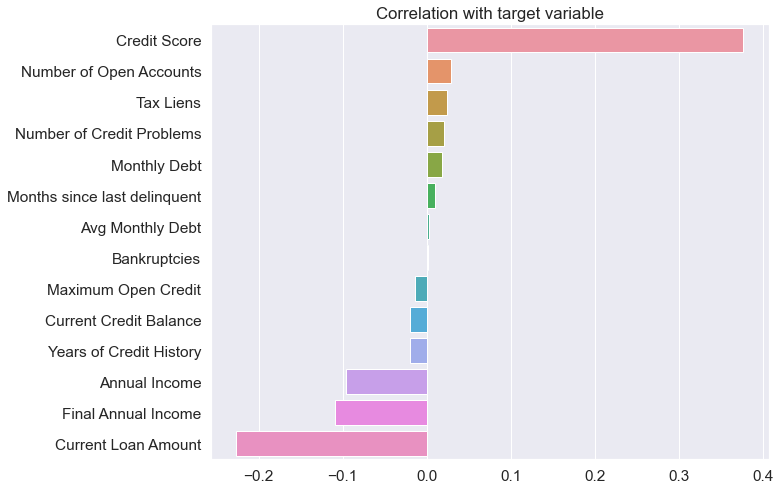

In [174]:
corr_with_target = data[NUM_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Видим, что кредитный рейтинг - это очень хороший признак, что вполне логично. Чем выше кредитный рейтинг у клиента, тем выше шанс, что он его отдаст. И наоборот, соответственно. Также хорошо влияет текущая сумма кредита. Добавленный признак Final Annual Income оказался полезнее, чем просто Annual Income. В этом есть есть смысл, поскольку важно учитывать не просто чистый доход, а со всеми выплатами. А вот средняя ежемесячная выплата, зависящая от количества открытых счетов, никак не влияет.

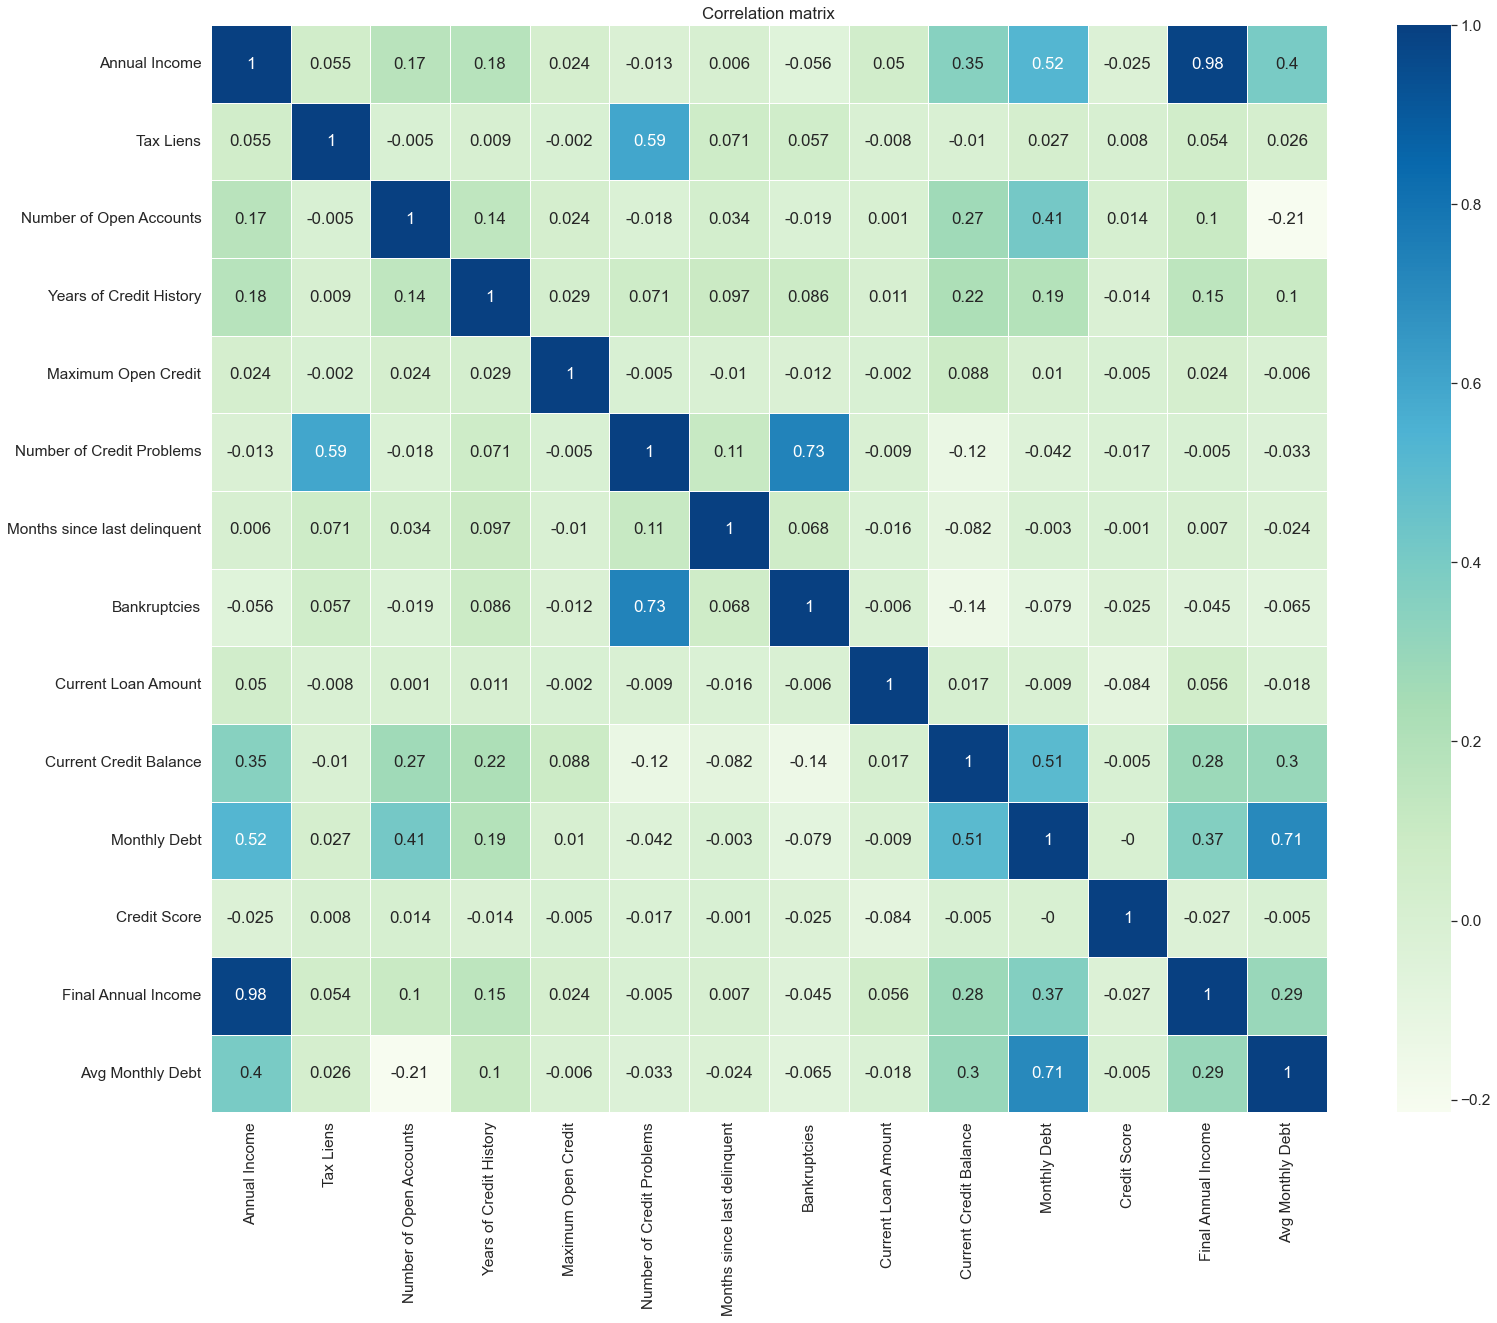

In [175]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)
sns.heatmap(data[NUM_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Есть признаки, которые неплохо коррелируют друг с другом, поэтому на основании этого можно создать несколько новых признаков (созданы в начале раздела "Обработка признаков"). В целом можно судить о том, что признаки достаточно уникальны и независимы.

# Обучение

## Нормализация данных 

In [176]:
scaler = StandardScaler()

df_norm = data.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

data = df_norm.copy()

## Разбиение данных 

In [177]:
X = data.drop(columns=TARGET_NAME)
y = data[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=41)

## Балансируем данные 

In [178]:
# Создадим функцию для балансировки

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [179]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3774
1    2952
Name: Credit Default, dtype: int64

In [180]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

## Обучаем модель при помощи CatBoostClassifier, поскольку хорошо работает с категориальными признаками 

In [181]:
# Создадим функцию для создания отчёта

def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [182]:
# Обучаем модель и показываем результаты в виде отчёта

model = CatBoostClassifier(n_estimators=500, max_depth=3, silent=True, random_state=41)
model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.86      0.81      3774
           1       0.78      0.66      0.71      2952

    accuracy                           0.77      6726
   macro avg       0.77      0.76      0.76      6726
weighted avg       0.77      0.77      0.77      6726

VALID

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1613
           1       0.53      0.55      0.54       637

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1308  305
1                288  349


## Выбираем порог вероятности для определения класса

In [183]:
# Создадим функцию выбора порога вероятности для определения класса

def show_proba_calibration_plots(y_predicted_proba, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_proba, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_proba > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_proba > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_proba > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

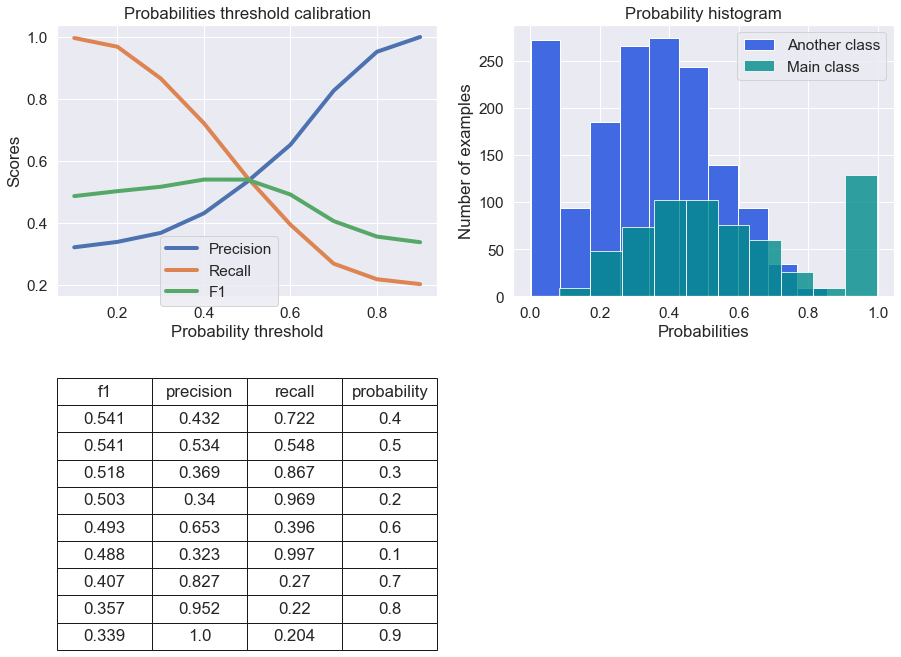

In [184]:
show_proba_calibration_plots(y_valid_pred_proba, y_valid)

## Посмотрим на важность признаков 

In [185]:
# Создадим функцию для отображения важности признаков

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

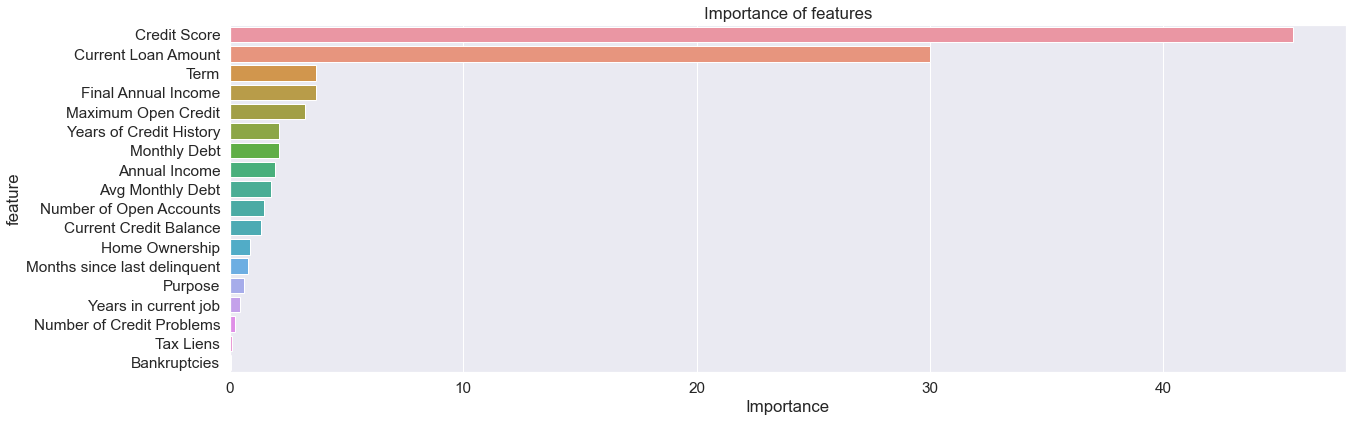

In [186]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top = 9)

Видим, что кредитный рейтинг и текущая сумма кредита действительно важные признаки. Стоит отметить, что Credit Score слишком сильный признак, если сравнивать с другим (заполняет почти всё пространство), но благодаря признаку Current Loan Amount создаётся некий баланс. Из добавленных признаков оба оказались неплохими (даже Avg Monthly Debt, который изначально не казался таким). Их можно использовать в обучении.

In [187]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Term',
 'Final Annual Income',
 'Maximum Open Credit',
 'Years of Credit History',
 'Monthly Debt',
 'Annual Income',
 'Avg Monthly Debt']

Срок кредита (Term) оказался единственным признаком среди категориальных, которые можно отнести к важным. Тем не менее, следует его учесть.

In [188]:
NEW_CAT_FEATURE_NAMES = ['Term']

## Обучим модель с учётом важности признаков 

In [189]:
# Обучаем модель с учётом важности признаков, показываем результаты в виде отчёта

final_model = CatBoostClassifier(n_estimators=500, max_depth=3, silent=True, random_state=41)
final_model.fit(X_train[important_features_top], y_train, cat_features=NEW_CAT_FEATURE_NAMES)

y_train_pred = final_model.predict(X_train[important_features_top])
y_valid_pred = final_model.predict(X_valid[important_features_top])
y_valid_pred_proba = final_model.predict_proba(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      3774
           1       0.78      0.66      0.71      2952

    accuracy                           0.77      6726
   macro avg       0.77      0.76      0.76      6726
weighted avg       0.77      0.77      0.76      6726

VALID

              precision    recall  f1-score   support

           0       0.81      0.80      0.81      1613
           1       0.52      0.54      0.53       637

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1296  317
1                295  342


## Выполним предсказание на тестовой выборке 

In [190]:
# Создадим функцию, при помощи которой можно будет конвертировать предсказанные значения в основной класс (0 или 1)

def convertation_to_main_class(proba, threshold):
    function = lambda x: 0 if x < threshold else 1
    vectorize_function = np.vectorize(function)
    return vectorize_function(proba)

In [191]:
y_test_pred_proba = final_model.predict_proba(test[important_features_top])[:, 1]
y_test_pred = convertation_to_main_class(y_test_pred_proba, threshold = 0.5)

## Сохраняем полученные предсказания 

In [192]:
preds = pd.DataFrame()
preds['Credit Default'] = y_test_pred
preds.head()

,Credit Default
0,1
1,1
2,1
3,1
4,1


In [193]:
preds.to_csv('ASolovei_predictions.csv', index = False)